# Introduction to Bayesian modeling with PyMC3

This post is devoted to give an introduction to Bayesian modeling using [PyMC3](https://pymc-devs.github.io/pymc3/notebooks/getting_started.html), an open source probabilistic programming framework written in Python. Part of this material was presented in the Python Users Berlin (PUB) meet up.

<img src="images/PyMC3_banner.svg" alt="html" style="width: 400px;"/>

Why PyMC3? As described in the documentation:

> - PyMC3’s user-facing features are written in pure Python, it leverages [Theano](http://deeplearning.net/software/theano/) to transparently transcode models to C and compile them to machine code, thereby boosting performance. 

> - Theano is a library that allows expressions to be defined using generalized vector data structures called tensors, which are tightly integrated with the popular [NumPy](http://www.numpy.org/) ndarray data structure.

In addition, from a practical point of view, PyMC3 syntax is very transpartent from the mathematical point of view.

This post does not aim to give a full treatment of the ~~mathematical details~~, as there are many good (complete and detailed) references around these topics (some of them colected at the end of the post). Also, we are not going to dive deep into PyMC3 as all the details can be found in the documentation. Instead, we are interested in giving an overview of the basic mathematical concepts combined with examples (written in Python code). Still, we briefly describe the main idea behind [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method), a sampling method from which other methods are inspired from.

**Remark:** Among he rich literature in bayesian statistics I particularly recommend [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) by, Richard McElreath. It is an excellent conceptual and practical introduction to the subject. Moreover, the PyMC3 dev team trasnlated all of the [code into PyMC3](https://github.com/pymc-devs/resources/tree/master/Rethinking_2).

**Update:** This post has been updated to include better integration with [arviz](https://arviz-devs.github.io/arviz/) and update PyMC3 syntax.

## Mathematical Background

### Bayes Theorem

#### Frequentist vs Bayesian

> *The essential difference between frequentist inference and Bayesian inference is the same as the difference between the two interpretations of what a "probability" means*.

**Frequentist inference** is a method of statistical inference in which conclusions from data is obtained by emphasizing the frequency or proportion of the data. 

**Bayesian inference** is a method of statistical inference in which Bayes' theorem is used to update the probability for a hypothesis as more evidence or information becomes available.

#### Conditional Probability

Let $A$ and $B$ be two events, then the *conditional probability* of $A$ given $B$ is defined as the ratio

$$
P(A|B):=\frac{P(A\cap B)}{P(B)}
$$

*Remark:* Formally we have a [probability space](https://en.wikipedia.org/wiki/Probability_space) $(\Omega, \mathcal{F}, P)$, where $\Omega$ is the sample space, $\mathcal{F}$ is a $\sigma$-algebra on $\Omega$ and $P$ is a probability measure. The events $A$, and $B$ are elements of $\mathcal{F}$ and we assume that $P(B)\neq 0$.

Observe in particular

$$
P(A|B)P(B)=P(A\cap B)=P(B\cap A) = P(B|A)P(A)
$$

#### Bayes Theorem

From the last formula we obtain the relation

\begin{equation}
P(A|B)=\frac{P(B|A)P(A)}{P(B)}
\end{equation}

which is known as [Bayes Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem).

**Example:** Suppose you are in the U-Bahn and you see a person with long hair. You want to know the probablity that this person is a woman. Consider the events $A=\text{woman}$ and $B= \text{long hair}$. You want to compute $P(A|B)$. Suppose that you estimate $P(A)=0.5$, $P(B)=0.4$ and $P(B|A)=0.7$ (the probability that a woman has long hair). Then, given these prior estimated probabilities, Bayes theorem gives  

\begin{equation}
P(A|B)=\frac{P(B|A)P(A)}{P(B)} = \frac{0.7\times 0.5}{0.4} = 0.875.
\end{equation}

#### Bayesian Approach to Data Analysis

Assume that you have a sample of observations $y_1,..., y_n$ of a random variable $Y\sim f(y|\theta)$, where $\theta$ is a parameter for the distribution. Here we consider $\theta$ as a random variable as well. Following Bayes Theorem (its continuous version) we can write.

$$
f(\theta|y)=\frac{f(y|\theta)f(\theta)}{f(y)} = 
\displaystyle{\frac{f(y|\theta)f(\theta)}{\int f(y|\theta)f(\theta)d\theta}}
$$

- The function $f(y|\theta)$ is called the *likelihood*.

- $f(\theta)$ is the *prior* distribution of $\theta$.


Note that $f(y)$ *does not* depend on $\theta$ (just on the data), thus it can be considered as a "normalizing constant". In addition, it is often the case that the integral above is not easy to compute. Nevertheless, it is enough to consider the relation:

$$
f(\theta|y)  \propto \text{likelihood} \times \text{prior}.
$$

(Here $\propto$ denotes the proportionality relation)

## Example: Poisson Data

In order to give a better sense of the relation above we are going to study a concrete example. Consider $n$ samples of $Y\sim \text{Pois}(\lambda)$. Recall that the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) is given by:

$$
f(y_i|\lambda)=\frac{e^{-\lambda}\lambda^{y_i}}{y_i!}
$$

where $\lambda>0$. It is easy to verify that $E(Y)=\lambda$ and $Var(Y)=\lambda$. Parallel to the formal discussion, we are going to implement a numerical simulation:

### Prepare Notebook

In [22]:
import numpy as np
import pandas as pd
import scipy.special as sp
import scipy.stats as ss
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [10, 7]

%reload_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'png'

### Generate Sample Data

Let us generate some sample data (for we of course know the true parameter $\lambda$):

In [23]:
# We set a seed so that the results are reproducible.
SEED = 5
np.random.seed(SEED)

# number of samples.
n = 100

# true parameter.
lam_true = 2

# sample array.
y = np.random.poisson(lam=lam_true, size=n)

y

array([2, 4, 1, 0, 2, 2, 2, 2, 1, 1, 3, 2, 0, 1, 3, 3, 4, 2, 0, 0, 3, 6,
       1, 2, 1, 2, 5, 2, 3, 0, 1, 3, 1, 4, 1, 2, 4, 0, 6, 4, 1, 2, 2, 0,
       1, 2, 4, 4, 1, 3, 0, 3, 3, 2, 4, 2, 2, 1, 1, 2, 5, 2, 3, 0, 1, 1,
       1, 3, 4, 1, 3, 4, 2, 1, 2, 4, 2, 2, 1, 0, 2, 2, 3, 0, 3, 3, 4, 2,
       2, 1, 2, 1, 3, 0, 1, 0, 3, 3, 1, 2])

Let us plot the sample distribution:

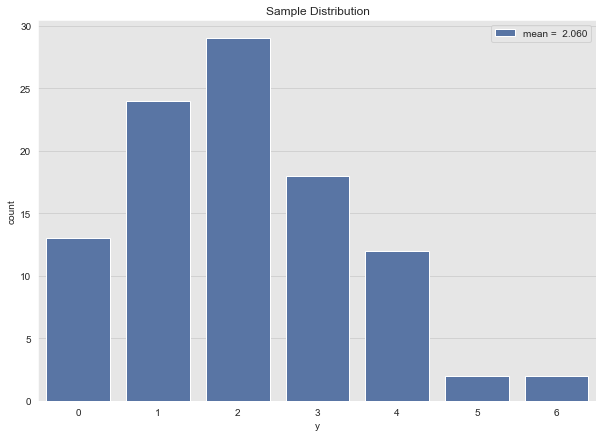

In [24]:
# Histogram of the sample.
fig, ax = plt.subplots()
sns.countplot(x=y, color=sns_c[0], label=f'mean = {y.mean(): 0.3f}', ax=ax)
ax.legend(loc='upper right')
ax.set(title='Sample Distribution', xlabel='y');

### Prior: Gamma Distribution

Let us consider a [gamma](https://en.wikipedia.org/wiki/Gamma_distribution) prior distribution for the parameter $\lambda \sim \Gamma(a,b)$. Recall that the density function for the gamma distribution is

$$
f(\lambda)=\frac{b^a}{\Gamma(a)}\lambda^{a-1} e^{-b\lambda}
$$

where $a>0$ is the *shape* parameter and $b>0$ is the *rate parameter*.

The *expected value* and *variance* of the gamma distribution is 

$$
E(\lambda)=\frac{a}{b}
\quad
\text{and}
\quad
Var(\lambda)=\frac{a}{b^2}
$$

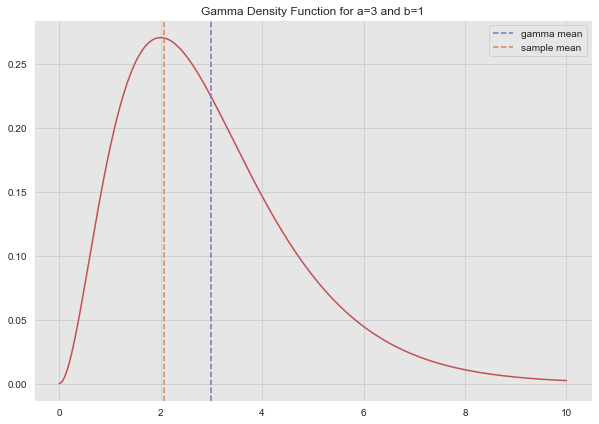

In [25]:
# Parameters of the prior gamma distribution.
a = 3 # shape
b = 1 # rate = 1/scale

x = np.linspace(start=0,stop=10, num=300)

fig, ax = plt.subplots()
ax.plot(x, ss.gamma.pdf(x, a=a, scale=1/b), color=sns_c[3])
ax.axvline(x= a /b, color=sns_c[4], linestyle='--', label='gamma mean')
ax.axvline(x= y.mean(), color=sns_c[1], linestyle='--', label='sample mean')
ax.legend()
ax.set(title=f'Gamma Density Function for a={a} and b={b}');

In [26]:
# Define the prior distribution.
prior = lambda x: ss.gamma.pdf(x, a=a, scale=1/b)

### Likelihood

As the observations are independent the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) function is

$$
f(y|\lambda)=\prod_{i=1}^{n} \frac{e^{-\lambda}\lambda^{y_i}}{y_i!}
=\frac{e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i}}{\prod_{i=1}^{n}y_i!}
$$

In [27]:
# Define the likelihood function.
def likelihood(lam, y):
    
    factorials = np.apply_along_axis(
        lambda x: sp.gamma(x + 1),
        axis=0,
        arr=y
    )
    
    numerator = np.exp(- lam * y.size) * (lam ** (y.sum()))
    
    denominator = np.multiply.reduce(factorials)
    
    return numerator / denominator  

### Posterior distribution for $\lambda$ up to a constant

As we are just interested in the structure of the posterior distribution, up to a constant, we see 

\begin{align}
f(\lambda|y)\propto & \: \text{likelihood} \times \text{prior}\\
\propto & \quad f(y|\lambda)f(\lambda)\\
\propto & \quad e^{-n\lambda}\lambda^{\sum_{i=1}^n y_i} \lambda^{a-1} e^{-b\lambda}\\
\propto & \quad \lambda^{\left(\sum_{i=1}^n y_i+a\right)-1} e^{-(n+b)\lambda}\\
\end{align}

In [28]:
# Define the posterior distribution.
# (up to a constant)
def posterior_up_to_constant(lam, y):
    return likelihood(lam=lam, y=y) * prior(lam)

Now we plot of the prior and (scaled) posterior distributionfor the parameter lambda. We multiply the posterior distribution function by the amplitude factor $2.5\times 10^{74}$ to make it visually comparable with the prior gamma distribution.

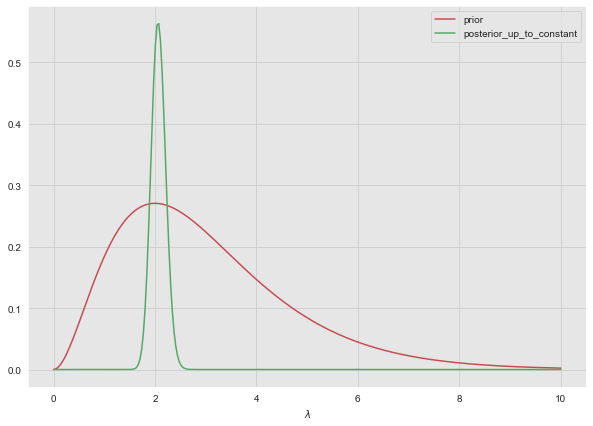

In [29]:
fig, ax = plt.subplots()
ax.plot(x, ss.gamma.pdf(x, a=a, scale=1/b), color=sns_c[3], label='prior')
ax.plot(x, 2.0e74 * posterior_up_to_constant(x,y), color=sns_c[2], label='posterior_up_to_constant')
ax.legend()
ax.set(xlabel='$\lambda$');

### True posterior distribution for $\lambda$

In fact, as  $f(\lambda|y) \propto\: \lambda^{\left(\sum_{i=1}^n y_i+a\right)-1} e^{-(n+b)\lambda}$, one verifies that the posterior distribution is again a gamma 

\begin{align}
f(\lambda|y) = \Gamma\left(\sum_{i=1}^n y_i+a, n+b\right)
\end{align}

This means that the gamma and Poisson distribution form a [conjugate pair](https://en.wikipedia.org/wiki/Conjugate_prior). 


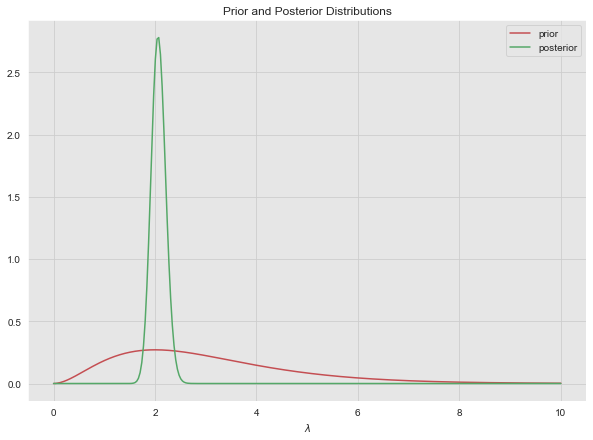

In [30]:
def posterior(lam, y):
    shape = a + y.sum()
    rate = b + y.size
    return ss.gamma.pdf(lam, shape, scale=1/rate)


fig, ax = plt.subplots()
ax.plot(x, ss.gamma.pdf(x, a=a, scale=1/b), color=sns_c[3], label='prior')
ax.plot(x, posterior(x,y), color=sns_c[2], label='posterior')
ax.legend()
ax.set(title='Prior and Posterior Distributions', xlabel='$\lambda$');

We indeed see how the posterior distribution is concentrated around the true parameter $\lambda=2$.

Note that the posterior mean is

\begin{align}
\frac{\sum_{i=1}^n y_i+a}{n+b} = \frac{b}{n+b}\frac{a}{b}+\frac{n}{n+b}\frac{\sum_{i=1}^n y_i}{n}
\end{align}

That is, it is a weighted average of the prior mean $a/b$ and the sample average $\bar{y}$. As $n$ increases, 

\begin{align}
\lim_{n\rightarrow +\infty}\frac{b}{n+b}\frac{a}{b}+\frac{n}{n+b}\frac{\sum_{i=1}^n y_i}{n} = \bar{y}.
\end{align}


In [31]:
# Posterior gamma parameters.
shape = a + y.sum()
rate = b + y.size

# Posterior mean.
print(f'Posterior Mean = {shape / rate: 0.3f}')

Posterior Mean =  2.069


## Markov Chain Monte Carlo  (MCMC) Approach

In the last example the posterior distribution was easy to identify. However, in paractice this is not usually the case and therefore, via Bayes Theorem, we would only know the posterior distribution up to a constant. This motivates the idea of using Monte Carlo simulation methods. How can we sample from a distribution that we do not know? The Metropolis–Hastings algorithm, explaned next, is one approach to tackle this problem.

### Metropolis–Hastings algorithm

Let $\phi$ be a function that is proportional to the desired probability distribution $f$. 

**Initialization:**

Pick $x_{0}$ to be the first sample, and choose an arbitrary probability density 

\begin{equation}
g(x_{n+1}| x_{n})
\end{equation}

that suggests a candidate for the next sample value $x_{n+1}$. Assume $g$ is symmetric.

**For each iteration:**

Generate a candidate $x$ for the next sample by picking from the distribution $g(x|x_n)$. Calculate the *acceptance ratio*

\begin{equation}
\alpha := \frac{f(x)}{f(x_n)} = \frac{\phi(x)}{\phi(x_n)}
\end{equation}

If $\alpha \geq 1$, automatically accept the candidate by setting

\begin{equation}
x_{n+1} = x.
\end{equation}

Otherwise, accept the candidate with probability $\alpha$. If the candidate is rejected, set

\begin{equation}
x_{n+1} = x_{n}.
\end{equation}

Why does this algorithm solve the initial problem? The full explanation is beyond the scope of this post (some references are provided at the end). It relies in the in the following result.

### Ergodic Theorem for Markov Chains 

**Theorem (Ergodic Theorem for Markov Chains)** If $\{x^{(1)} , x^{(2)} , . . .\}$ is an *irreducible*, *aperiodic* and *recurrent* [Markov chain](https://en.wikipedia.org/wiki/Markov_chain), then there is a unique probability distribution $\pi$ such that as $N\longrightarrow\infty$,

- $P(x^{(N)} ∈ A) \longrightarrow \pi(A)$.
- $\displaystyle{\frac{1}{N}\sum_{n=1}^{N} g(x^{(n)})) \longrightarrow    \int g(x)\pi(x) dx }$.

*Recall:*

- A Markov chain is said to be **irreducible** if it is possible to get to any state from any state. 

- A state $n$ has **period** $k$ if any return to state $n$ must occur in multiples of $k$ time steps.

- If $k=1$, then the state is said to be **aperiodic**. 

- A state $n$ is said to be **transient** if, given that we start in state $n$, there is a non-zero probability that we will never return to $i$. 

- A state $n$ is **recurrent**  if it is not transient.


**Remark:** PyMC3 has many modern samplers which are in general better that MCMC, like [Hamiltonian Monte Carlo (HMC)](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo) and [No-U-Turn Sampler](https://arxiv.org/abs/1111.4246). For more details I recommend checking [Statistical Rethinking - Chapter 9](https://xcelab.net/rm/statistical-rethinking/) and [Michael Betancourt's blog](https://betanalpha.github.io/writing/).

## PyMC3 Syntax

Now we perform a variant of MCMC simulation for the data described above. Note how easy is to write the model from the mathematical description.

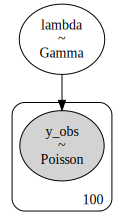

In [32]:
with pm.Model() as toy_model:
    # Define the prior of the parameter lambda.
    lam = pm.Gamma('lambda', alpha=a, beta=b)
    # Define the likelihood function.
    y_obs = pm.Poisson('y_obs', mu=lam, observed=y)

pm.model_to_graphviz(toy_model)

In [33]:
with toy_model:
    # Consider 2000 draws and 4 chains.
    trace = pm.sample(
        tune=1000,
        draws=4000,
        chains=4,
        cores=-1,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [lambda]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8854386248413988, but should be close to 0.8. Try to increase the number of tuning steps.


Let us plot the *trace* off the posterior distribution. We see 4 independent chains which do not seem correlated.

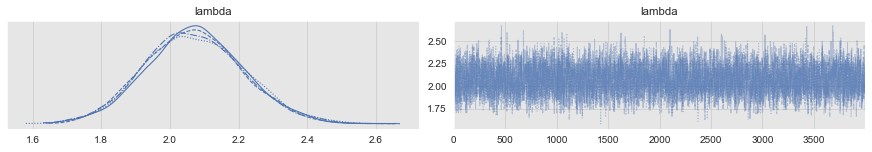

In [34]:
from arviz.utils import Numba
Numba.disable_numba()
az.plot_trace(data=trace);

Let us get some diagnostics of the sampling:

In [35]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda,2.07,0.143,1.802,2.338,0.002,0.001,6658.0,10938.0,1.0


- The inferred mean of the $\lambda$ parameter is very close to the true value $2$.
- The `r_hat` denotes the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html#gelman-rubin-statistic), which indicates convergence of the chains. Values close to 1.0 mean convergence.

We can plot the mean and [highest density interval](https://en.wikipedia.org/wiki/Credible_interval) of the posterior distribution.

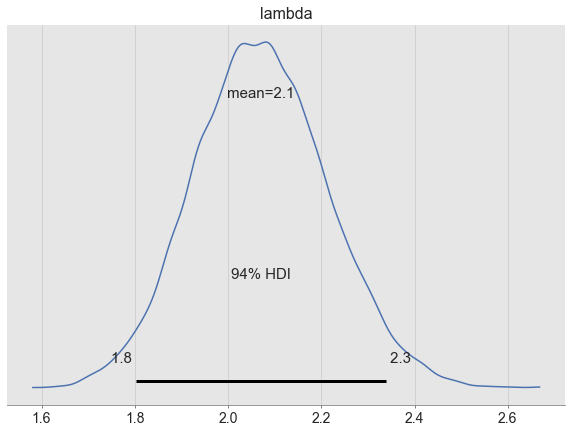

In [36]:
fig, ax = plt.subplots()
az.plot_posterior(data=trace, ax=ax);

Let us now do some posterior predictive checks, i.e. sample observations using the distribution of the parameter $\lambda$.

In [37]:
with toy_model:
    
    forecast_1 = az.from_pymc3(
        posterior_predictive=pm.sample_posterior_predictive(trace=trace)
    )

posterior_sampels = forecast_1.posterior_predictive['y_obs'].values.flatten()

We can now compare the distributions:

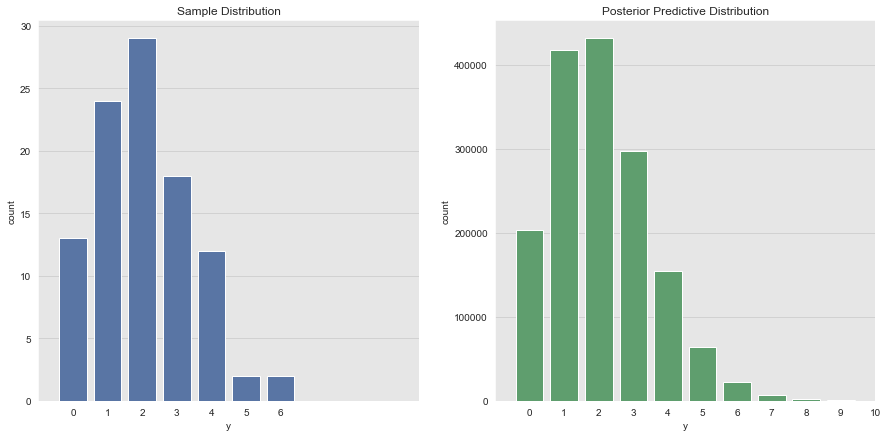

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.countplot(x=y, color=sns_c[0], ax=ax[0])
ax[0].set(title='Sample Distribution', xlabel='y', xlim=(-1, 10))
sns.countplot(x=posterior_sampels, color=sns_c[2], ax=ax[1])
ax[1].set(title='Posterior Predictive Distribution', xlabel='y', xlim=(-1, 10));

The shape of the distributions look very similar!

## Bayesian Hierarchical Modeling: A Chocolate Cookies Example.

<img src="images/monster.jpg" alt="html" style="width: 400px;"/>

Now we are going to treat a more complicated example which illustrates a hierarchical model, which is one of the most frequent use cases for Bayesian models.

This case of study is taken from the (strongly recommended!) online course [**Bayesian Statistics: Techniques and Models**](https://www.coursera.org/learn/mcmc-bayesian-statistics). In the course content, the MCMC simulations are done with [JAGS](http://mcmc-jags.sourceforge.net/) in [R](https://www.r-project.org/). As a matter of fact, this course motivated me to explore an analogous tool for Python.

### Data

Assume there is a big factory producing chocolate cookies around the world. The cookies follow a unique recipe. You want to study the chocolate chips distribution for cookies produced in $5$ different locations. Let us read the data into a pandas dataframe.

In [39]:
cookies = pd.read_csv('data/cookies.dat', sep = ' ')

cookies.head()

,chips,location
0,12,1
1,12,1
2,6,1
3,13,1
4,12,1


In data set we have $5$ different locations with $30$ observations each.

In [40]:
cookies.value_counts('location')

location
1    30
2    30
3    30
4    30
5    30
dtype: int64

Let us start by plotting the sample data distribution:

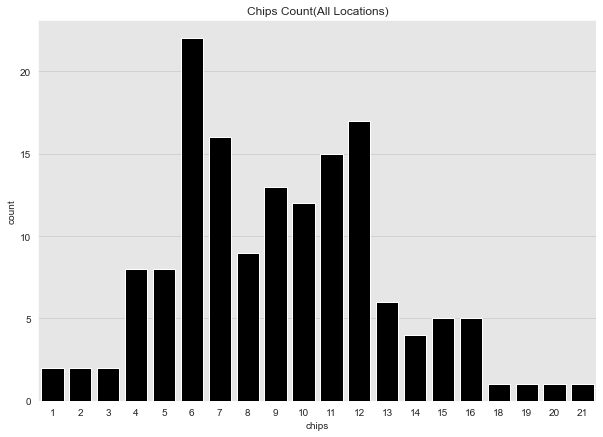

In [41]:
# Histogram distribution of chocolate chips for all cookies.
fig, ax = plt.subplots()
sns.countplot(x='chips', data=cookies, color='black', ax=ax);
ax.set(title='Chips Count(All Locations)');

Now let us plot the distribution per location:

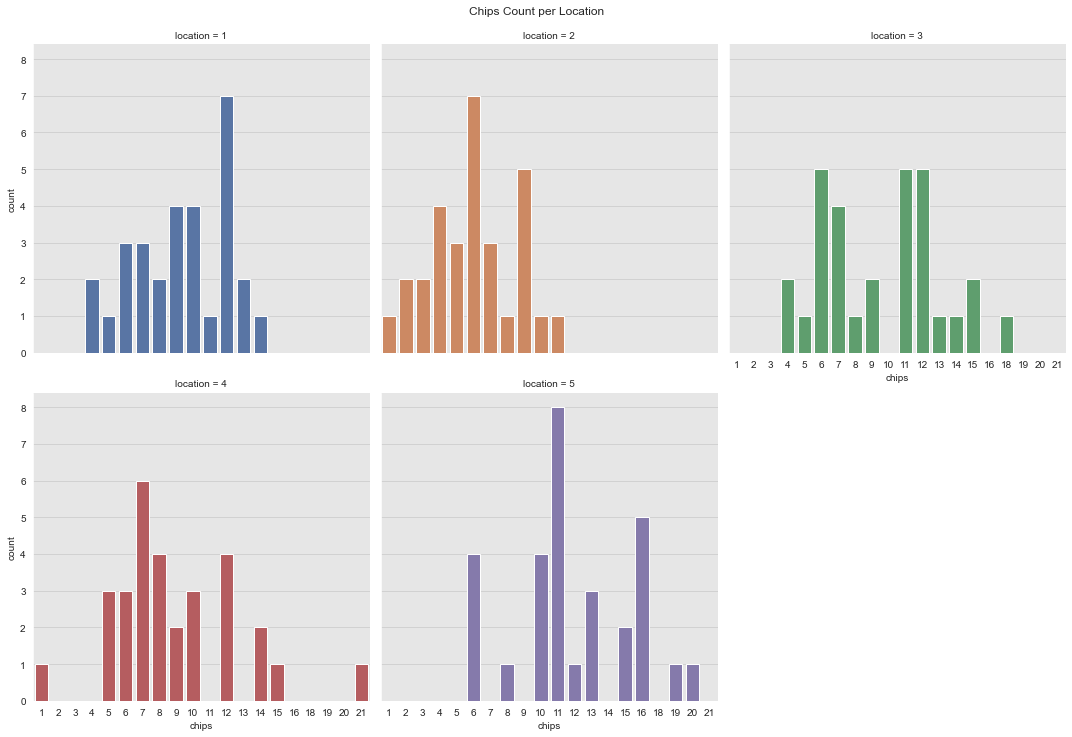

In [42]:
g = sns.catplot(
    x='chips',
    data=cookies,
    col='location',
    hue='location',
    kind='count',
    dodge=False,
    col_wrap=3
)
g.fig.suptitle('Chips Count per Location', y=1.02);

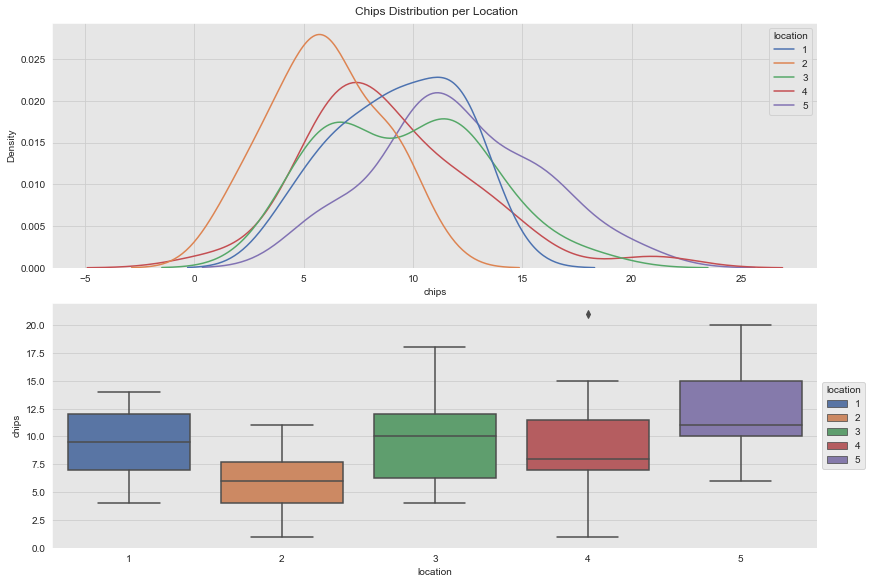

In [43]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 8), constrained_layout=True
)
sns.kdeplot(
    x='chips',
    data=cookies,
    hue='location',
    palette=sns_c[:5],ax=ax[0]
)
sns.boxplot(
    x='location',
    y='chips',
    data=cookies,
    hue='location',
    palette=sns_c[:5],
    dodge=False,
    ax=ax[1]
)
ax[1].legend(title='location', loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('Chips Distribution per Location');

In view of these plots and the problem statement, one would consider the following aspects to model the data:

- On the one hand side you would imagine that the distribution across the locations is similar, as they all come from a unique recipe. This is why you may want to model all locations together (pooling). 

- On the other hand, in reality, as the locations are not exactly the same you might expect some differences between each location.  This is why you may want to model all locations separately (no pooling).

Hence, we would like to have a mix of the two settings described above (partial pooling). Hierarchical models are a great way of doing this. How? Well, we can assume $5$ different parameters for each location, but all of them coming from a common global (hyper) prior distribution.


### The Model: Hierarchical Approach

- Hierarchical Model:

We model the chocolate chip counts by a Poisson distribution with parameter $\lambda$. Motivated by the example above, we choose a gamma prior.

\begin{align}
\text{chips} \sim  \text{Pois}(\lambda)
\quad\quad\quad
\lambda \sim  \Gamma(\alpha, \beta)
\end{align}

- Parametrization:

We parametrize the shape and scale of the gamma prior with the mean $\mu$ and variance $\sigma^2$.

\begin{align}
\alpha =\frac{\mu^2}{\sigma^2}
\quad\quad\quad
\beta=\frac{\mu}{\sigma^2}
\end{align}

- Prior Distributions:

We further impose prior for these parameters

\begin{align}
\mu  \sim  \Gamma(2,1/5)
\quad\quad\quad
\sigma  \sim  \text{Exp}(1)
\end{align}

Let us generate the plots of the prior distributions:

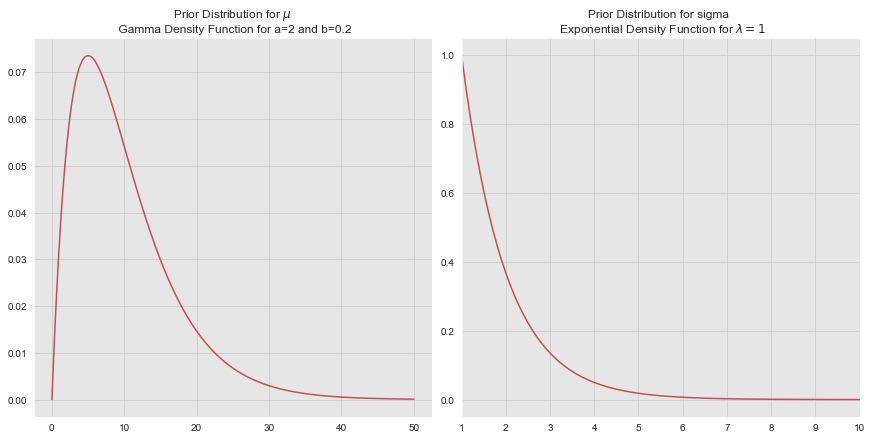

In [44]:
x = np.linspace(start=0, stop=50, num=500)

fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True
)
ax[0].plot(x, ss.gamma.pdf(x, a=2, scale=5), color=sns_c[3])
ax[0].set(
    title=f'Prior Distribution for $\mu$ \n Gamma Density Function for a={2} and b={1/5}'
)
ax[1].plot(x, ss.expon.pdf(x,1), color=sns_c[3])
ax[1].set(
    title='Prior Distribution for sigma \n Exponential Density Function for $\lambda=1$',
    xlim=(1, 10)
);

We will do some prior predictive sampling to understand the choice of these priors.

Let us write the model in PyMC3. Note how the syntax mimics the mathematical formulation.

In [45]:
# Define useful variables and coordinates in order to 
# specify shapes of the distributions.
chips = cookies['chips'].values
location_idx, locations = cookies['location'].factorize(sort=True)

COORDS = {
    'obs': cookies.index,
    'location': locations
}

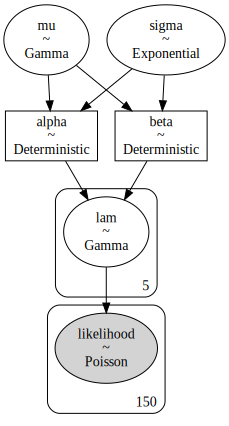

In [46]:
with pm.Model(coords=COORDS) as cookies_model:
    # Hyperpriors:
    # Prior distribution for mu.
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)
    # Prior distribution for sigma2.
    sigma = pm.Exponential('sigma', 1.0)
    # Parametrization for the shape parameter.
    alpha =  pm.Deterministic('alpha', mu**2 / sigma**2)
    # Parametrization for the scale parameter.
    beta = pm.Deterministic('beta', mu / sigma**2)
    # Prior distribution for lambda.
    lam = pm.Gamma(
        'lam', 
        alpha=alpha, 
        beta=beta, 
        dims='location'
    )
    # Likehood function.
    rate = lam[location_idx]
    likelihood = pm.Poisson(
        'likelihood',
        mu=rate,
        observed=chips,
        dims='obs'
    )
    # Sample prior distribution.
    prior_predictive = pm.sample_prior_predictive()

pm.model_to_graphviz(cookies_model)

Let us what the model predicts using the prior before seeing the data:

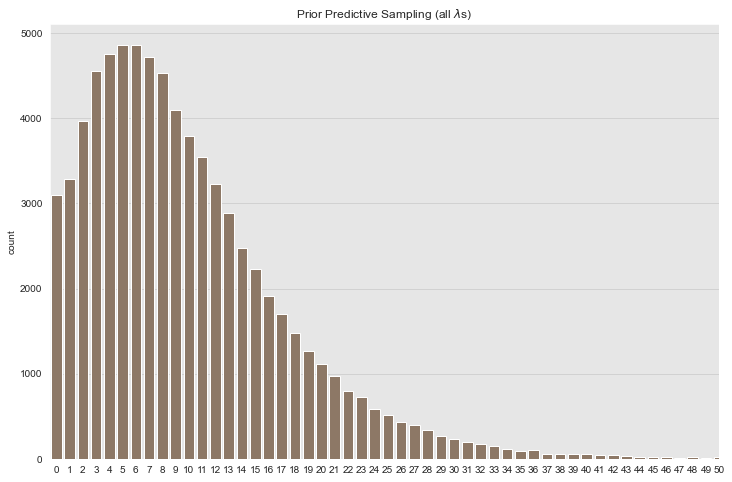

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.countplot(
    x=prior_predictive['likelihood'].flatten(), 
    color=sns_c[5],
    ax=ax
)
ax.set(
    title='Prior Predictive Sampling (all $\lambda$s)', 
    xlim=(None, 50)
);

Now let us pass the data trough the model and sample from the posterior distribution.

In [48]:
with cookies_model:

    cookies_trace =pm.sample(
        tune=1000,
        draws=4000,
        chains=4,
        cores=-1,
        return_inferencedata=True,
        target_accept=0.95
    )

    posterior_predictive = az.from_pymc3(
        posterior_predictive=pm.sample_posterior_predictive(trace=cookies_trace)
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, sigma, mu]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 28 seconds.


0, dim: obs, 150 =? 150


Let us plot the traces:

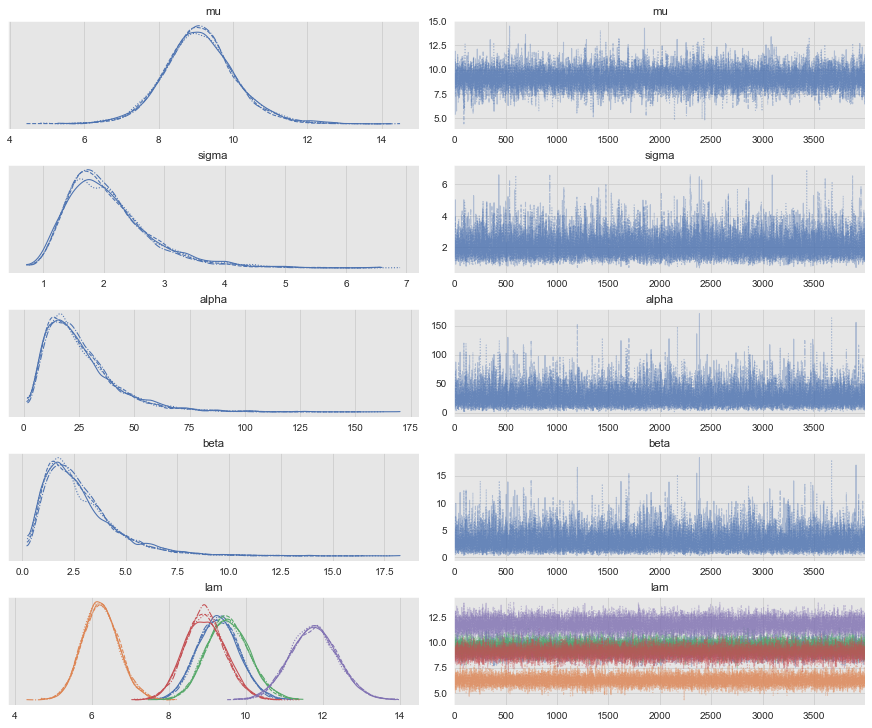

In [49]:
az.plot_trace(cookies_trace);

From the traceplot we see that the chains have converged. Let us compute the mean and hdi for each posterior component.

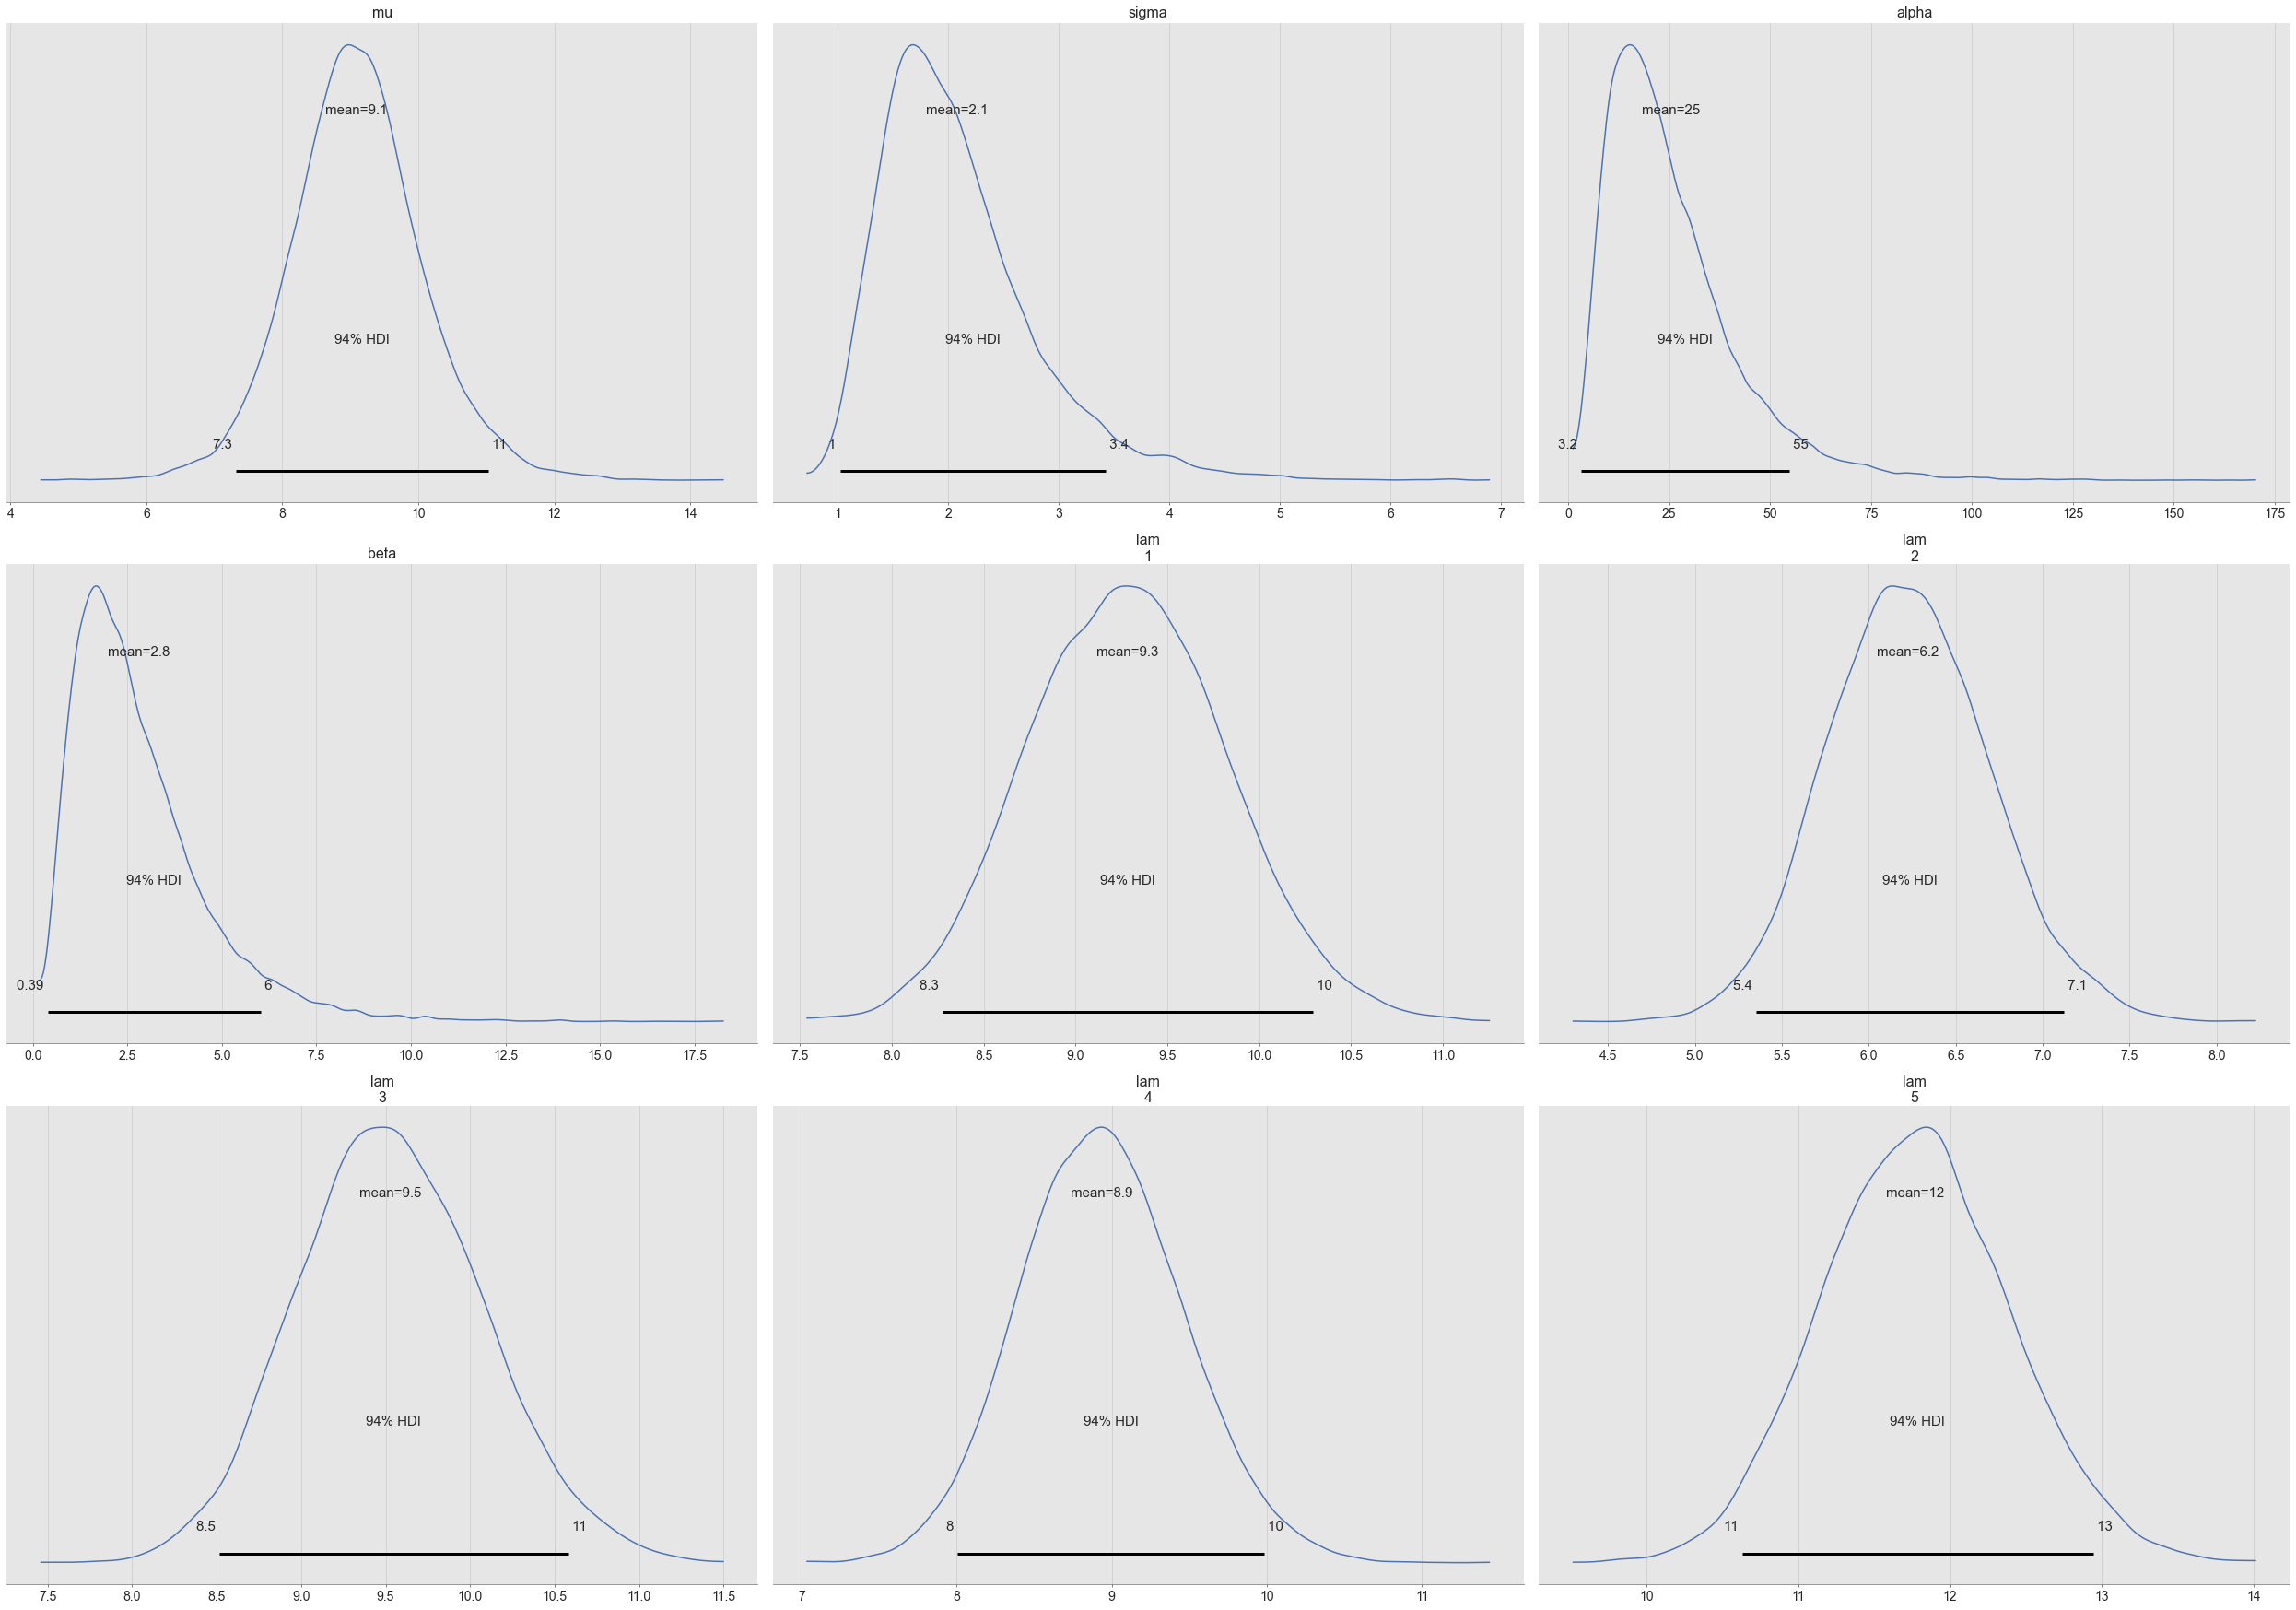

In [50]:
az.plot_posterior(cookies_trace);

We can also have a detailed summary of the posterior distribution for each parameter:

In [51]:
az.summary(cookies_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,9.093,0.975,7.321,11.032,0.010,0.007,9310.0,7683.0,1.0
sigma,2.075,0.706,1.021,3.424,0.007,0.005,12459.0,10446.0,1.0
alpha,25.461,16.280,3.163,54.773,0.142,0.102,12922.0,11376.0,1.0
beta,2.806,1.785,0.388,6.020,0.016,0.011,12744.0,11415.0,1.0
lam[0],9.284,0.538,8.277,10.291,0.004,0.003,20686.0,12217.0,1.0
lam[1],6.225,0.468,5.352,7.121,0.003,0.002,17905.0,12063.0,1.0
lam[2],9.530,0.550,8.513,10.582,0.004,0.003,17214.0,12147.0,1.0
lam[3],8.938,0.526,8.007,9.980,0.004,0.003,17649.0,10975.0,1.0
lam[4],11.770,0.618,10.629,12.941,0.005,0.003,16369.0,11845.0,1.0


The `r_hat` are all very close to $1.0$ which is what we want. There are many other [diagnostics](https://arviz-devs.github.io/arviz/api/diagnostics.html) available in  [arviz](https://arviz-devs.github.io/arviz/index.html).

We can also test for correlation between samples in the chains. We are aiming for zero auto-correlation to get "random" samples from the posterior distribution.

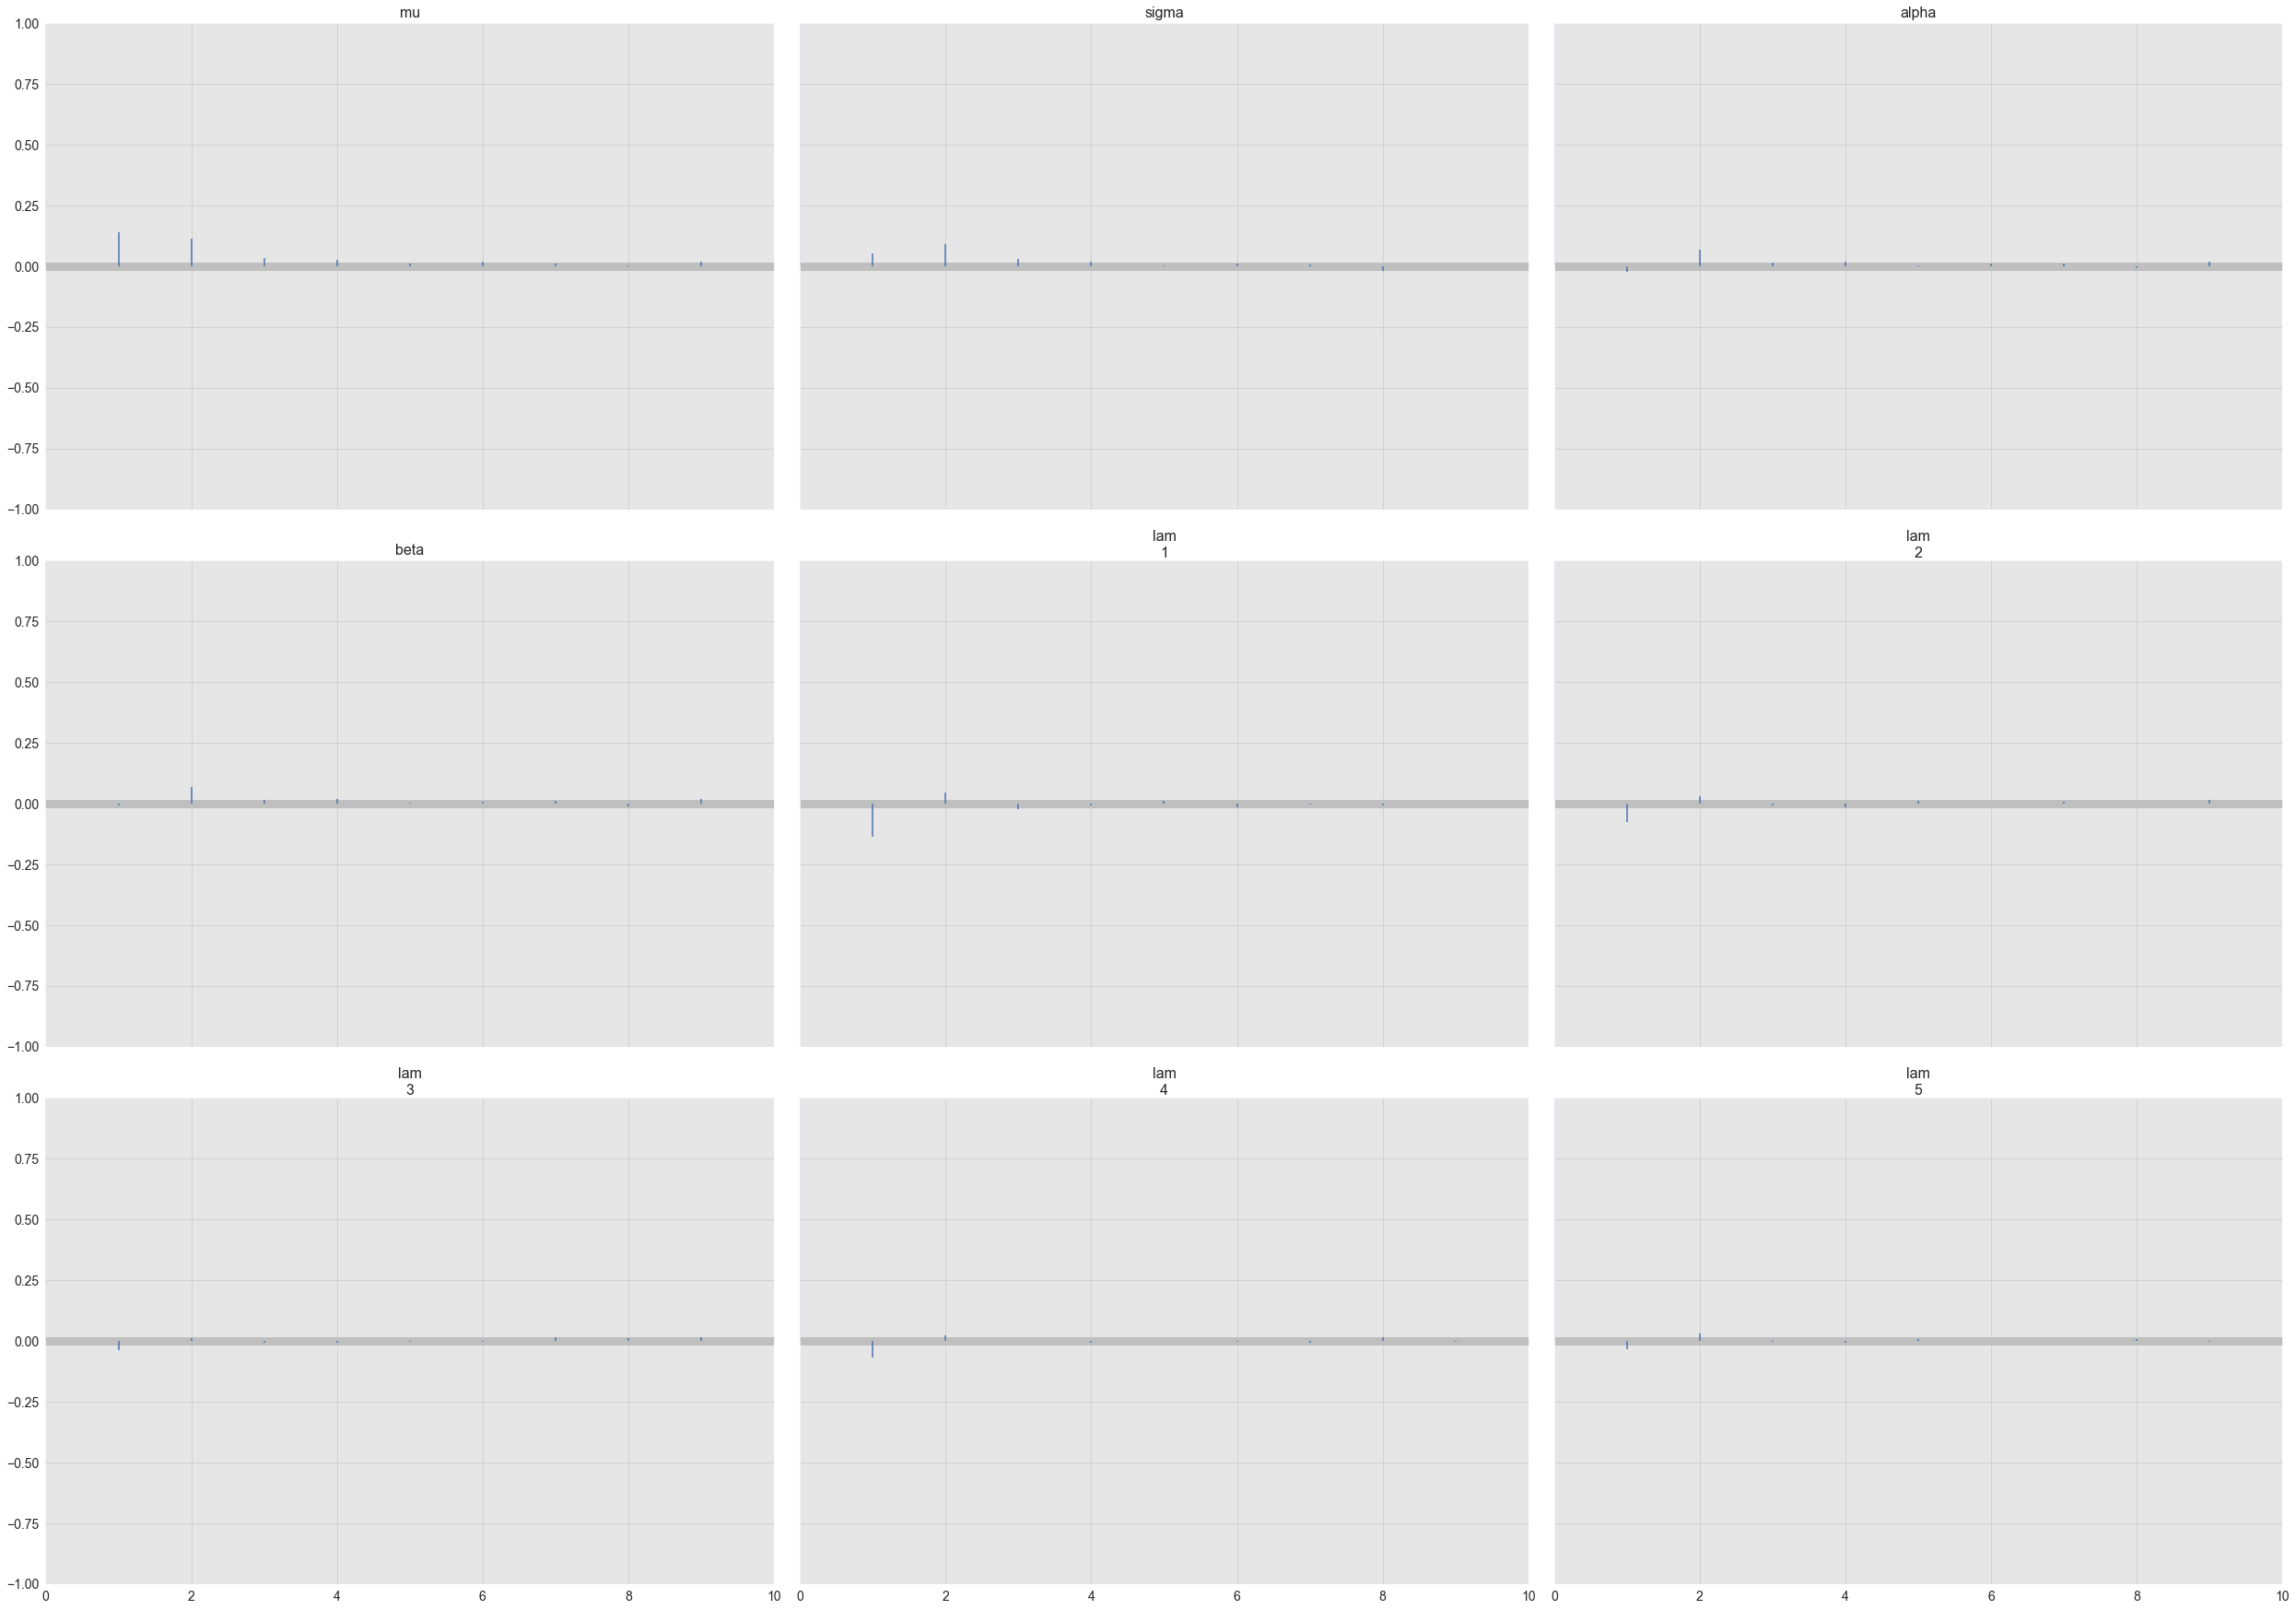

In [52]:
# Auto-correlation of the parameter sigma for the 3 chains.
az.plot_autocorr(data=cookies_trace, combined=True, max_lag=10);

From these plots we see that the auto-correlation is not problematic. Moreover, one can get an estimate of the effective sample size of the chains from the columns `ess_` in the summary table above, see [arviz.ess](https://arviz-devs.github.io/arviz/api/generated/arviz.ess.html).

Finally, we can compute the [Watanabe–Akaike information](https://en.wikipedia.org/wiki/Watanabe–Akaike_information_criterion) (see [arviz.waic](https://arviz-devs.github.io/arviz/api/generated/arviz.waic.html)) and the [Pareto-smoothed importance sampling leave-one-out cross-validation](https://arxiv.org/abs/1507.04544) (see [arviz.loo](https://arviz-devs.github.io/arviz/api/generated/arviz.loo.html)), which are metrics to estimate out-of-sample performance.

In [53]:
stats_df = pd.concat([
    pd.DataFrame(az.loo(data=cookies_trace)),
    pd.DataFrame(az.waic(data=cookies_trace))
])
stats_df.columns = ['values']

stats_df 

/Users/juanitorduz/opt/anaconda3/envs/website_projects/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,values
loo,-394.846742
loo_se,10.68048
p_loo,5.807768
n_samples,16000
n_data_points,150
warning,False
loo_scale,log
waic,-394.840591
waic_se,10.6794
p_waic,5.801617


Another useful diagnostic for HCM algorithms is an energy plot, see [arviz.plot_energy](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_energy.html). These algorithms can me seen as a dynamical system of a physical particle where the total energy is conserved (see [The Geometric Foundations of Hamiltonian Monte Carlo](https://arxiv.org/abs/1410.5110)). In this plot we want the  *marginal and energy transition plots* to overlap as much as possible.

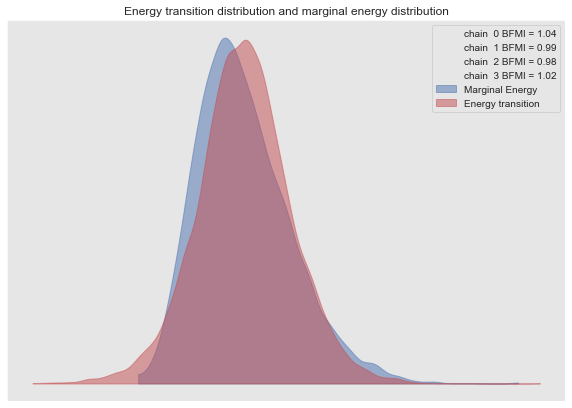

In [54]:
fig, ax = plt.subplots()

az.plot_energy(
    data=cookies_trace,
    fill_color=('C0', 'C3'),
    fill_alpha=(0.5, 0.5),
    ax=ax
)
ax.set(
    title='Energy transition distribution and marginal energy distribution'
);

### Posterior Predictive Distribution

Finally, we are going to illustrate how to use the simulation results to derive predictions.

#### Existing Locations

Let us generate posterior prediction checks for existing locations.

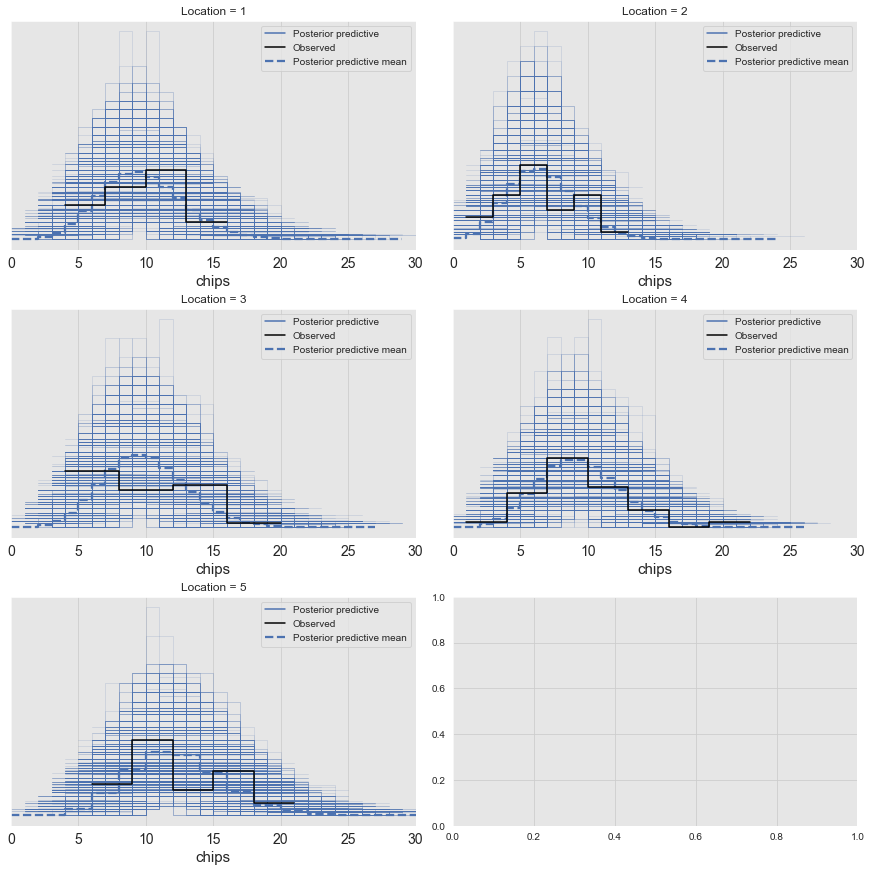

In [55]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(12, 12),
    constrained_layout=True
)

axes = axes.flatten()

for i, location in enumerate(locations):
    ax = axes[i]
    az.plot_ppc(
        data=posterior_predictive,
        coords={
            'obs': np.where(locations[location_idx] == location)
        },
        ax=ax
    )
    ax.legend(loc='upper right')
    ax.set(
        title=f'Location = {location}',
        xlabel='chips',
        xlim=(0, 30)
    )

The plots look very reasonable.

Let us now compare the sample and the posterior mean for each location.

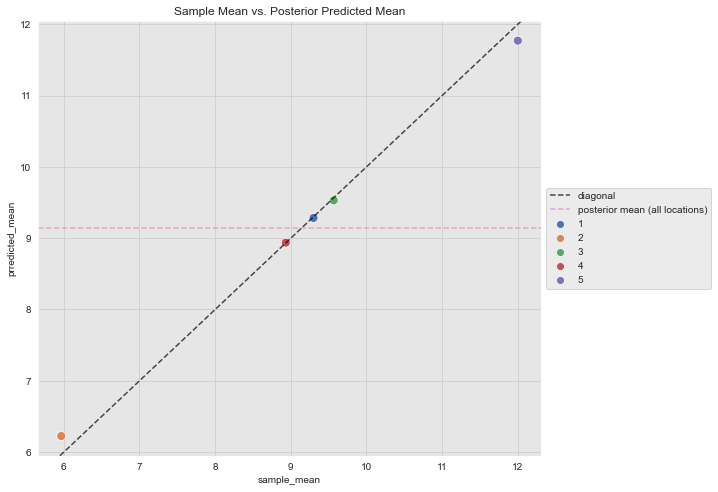

In [104]:
posterior_predictive_mean_lam = cookies_trace \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    .lam \
    .mean(axis=1)

posterior_predictive_mean_all_lam = cookies_trace \
    .posterior \
    .stack(sample=('chain', 'draw', 'location')) \
    .lam \
    .mean()

fig, ax = plt.subplots(figsize=(9, 8))

cookies \
    .groupby('location', as_index=False) \
    .agg(sample_mean=('chips', np.mean)) \
    .assign(prredicted_mean = posterior_predictive_mean_lam) \
    .pipe((sns.scatterplot, 'data'),
        x='sample_mean',
        y='prredicted_mean',
        hue='location',
        palette=sns_c[:5],
        s=80,
        ax=ax
    )

ax.axline(
    xy1=(9, 9),
    slope=1,
    color='black',
    linestyle='--',
    alpha=0.7,
    label='diagonal'

)
ax.axhline(
    y=posterior_predictive_mean_all_lam,
    color=sns_c[6],
    linestyle='--',
    alpha=0.7,
    label='posterior mean (all locations)'
)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(
    title='Sample Mean vs. Posterior Predicted Mean',
);

Note that locations 1, 3 and 4 are over the diagonal, which means that the sample and posterior predictive mean are pretty much the same. These values are actually quite close to the global posterior predictive mean. On the other hand locations 2 and 5 have higher and lower expected prediction means respectively. The reason is that the hierarchical model is trying to push them close to the global posterior mean. This phenomenon is called *shrinkage* and can be seen as a kind of regularization.

Let us deep dive in `location =1`. We want, for example, to compute the posterior probability that the next cookie generated in this location will have less that $7$ chips. First let us start by looking into the posterior distribution of $\lambda$ for this location.

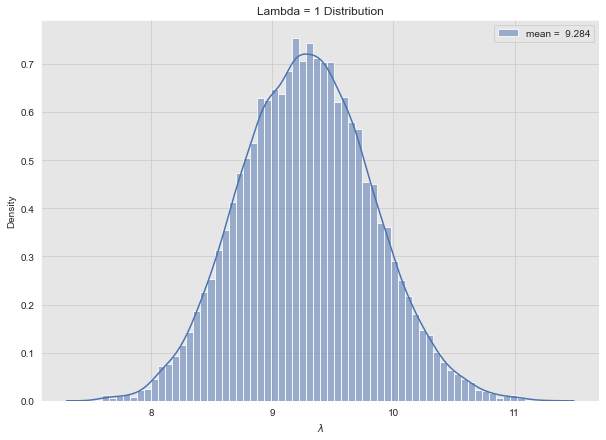

In [56]:
# Set location.
loc = 1
# Get posterior samples.
lambda_loc = cookies_trace \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['lam'][loc - 1, :].values
# Plot distribution.
fig, ax = plt.subplots()
sns.histplot(
    x=lambda_loc,
    stat='density',
    color=sns_c[0],
    alpha=0.5,
    label=f'mean = {lambda_loc.mean(): 0.3f}',
    ax=ax
)
sns.kdeplot(
    x=lambda_loc,
    color=sns_c[0],
    ax=ax
)
ax.legend()
ax.set(title=f'Lambda = {loc} Distribution', xlabel='$\lambda$');

Next, let us use these values san sample from a Poisson distribution to get the chips distribution.

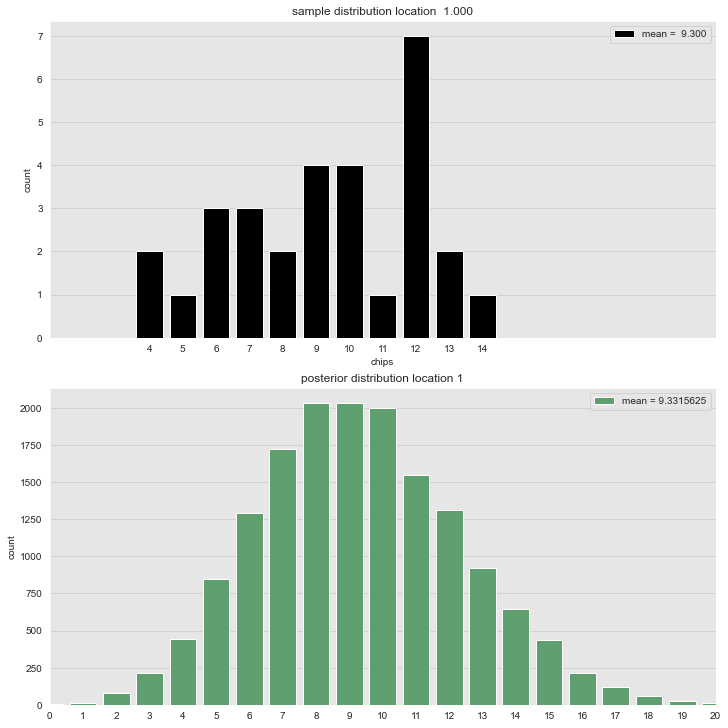

In [57]:
SEED = 5
np.random.seed(SEED)
# Sample from Poisson distribution using posterior samples from lambda.
samples_loc = np.random.poisson(lam=lambda_loc)
# Plot samples vs posterior distribution.
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 10), constrained_layout=True
)
sns.countplot(
    x='chips',
    data=cookies.query(f'location == {loc}'),
    color='black',
    label=f'mean = {cookies.query(f"location == {loc}")["chips"].mean(): 0.3f}',
    ax=ax[0]
)
ax[0].legend(loc='upper right')
ax[0].set(
    title=f'sample distribution location {loc: 0.3f}',
    xlim=(-3, 17)
)
sns.countplot(
    x=samples_loc,
    color=sns_c[2],
    label=f'mean = {samples_loc.mean()}',
    ax=ax[1]
)
ax[1].legend(loc='upper right')
ax[1].set(
    title=f'posterior distribution location {loc}',
    xlim=(0, 20)
);

Let us now compute the desired probability:

In [58]:
(samples_loc < 7).astype(float).mean()

0.1808125

**Remark:** We can also compute this probability using the `posterior_predictive` object directly.

In [59]:
samples_loc = posterior_predictive \
    .posterior_predictive \
    .stack(sample=('chain', 'draw')) \
    ['likelihood'][locations[location_idx] == loc] \
    .values \
    .flatten()

(samples_loc < 7).astype(float).mean()

0.18661875

#### For a new location

Now assume we want to open a new location. First, we want to compute the posterior probability that this new location has $\lambda_{new} > 15$. To do so, as we do not have data from new locations, we can start by sampling from the (hyper)-prior distribution:

In [60]:
alpha_samples = cookies_trace \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['alpha'].values

beta_samples = cookies_trace \
    .posterior \
    .stack(sample=('chain', 'draw')) \
    ['beta'].values

Let us plot the samples:

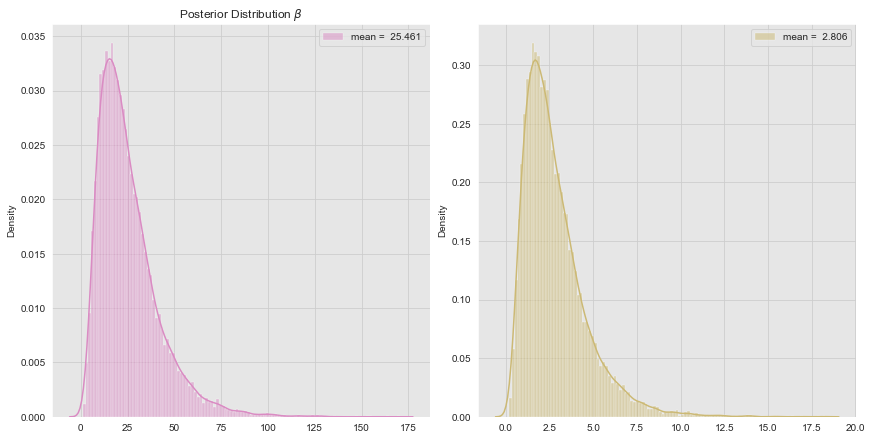

In [61]:
fig, ax = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True
)
sns.histplot(
    x=alpha_samples,
    stat='density',
    alpha=0.5,
    color=sns_c[6],
    label=f'mean = {alpha_samples.mean(): 0.3f}',
    ax=ax[0]
)
sns.kdeplot(
    x=alpha_samples,
    color=sns_c[6],
    ax=ax[0]
)
ax[0].legend()
ax[0].set(title=r'Posterior Distribution $\alpha$')
sns.histplot(
    x=beta_samples,
    stat='density',
    alpha=0.5,
    color=sns_c[8],
    label=f'mean = {beta_samples.mean(): 0.3f}',
    ax=ax[1]
)
sns.kdeplot(
    x=beta_samples ,
    color=sns_c[8],
    ax=ax[1]
)
ax[1].legend()
ax[0].set(title=r'Posterior Distribution $\beta$');

Next we sample to the the distribution of $\lambda_{new}$.

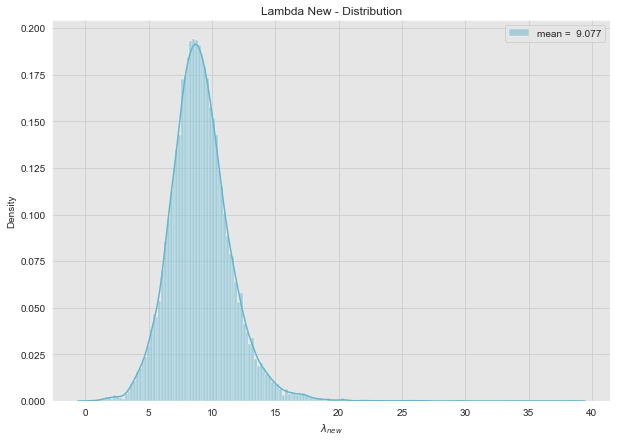

In [62]:
lambda_new_samples = np.random.gamma(alpha_samples, 1/beta_samples)

fig, ax = plt.subplots()
sns.histplot(
    x=lambda_new_samples,
    stat='density',
    alpha=0.5,
    color=sns_c[9],
    label=f'mean = {lambda_new_samples.mean(): 0.3f}',
    ax=ax
)
sns.kdeplot(
    x=lambda_new_samples,
    color=sns_c[9],
    ax=ax
)
ax.legend()
ax.set(title=f'Lambda New - Distribution', xlabel='$\lambda_{new}$');

To compute the desired probability we can simply do:

In [63]:
(lambda_new_samples > 15).astype(float).mean()

0.0164375

Finally, for this new location, we wan to estimate the probability for a cookie to have more than 15 chocolate chips. To do so we move to the next level in our hierarchical model. We sample from a Poisson distribution using the samples obtained for $\lambda_{new}$.

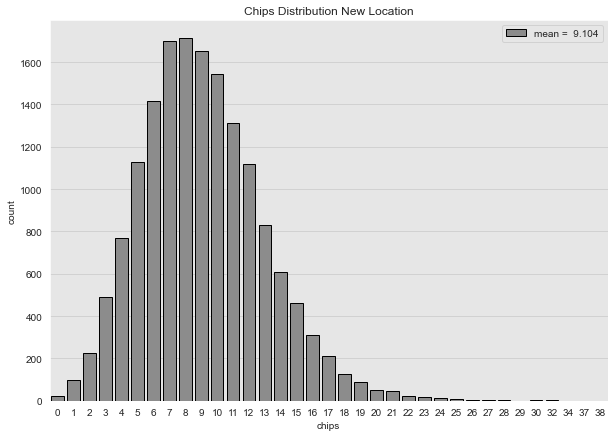

In [64]:
chips_new_location = np.random.poisson(lam=lambda_new_samples)

fig, ax = plt.subplots()
sns.countplot(
    x=chips_new_location,
    color=sns_c[7],
    edgecolor='black',
    label=f'mean = {chips_new_location.mean(): 0.3f}',
    ax=ax
)
ax.legend()
ax.set(title=f'Chips Distribution New Location', xlabel='chips');

We now can estimate the required probability:

In [65]:
(chips_new_location > 15).astype(float).mean()

0.0570625

---

## References and Further Reading

Here we provide some suggested references used in this post and also to go deeper in the subject.

### Bayesian Statistics

- [Bayesian Analysis with Python (Second edition), ](https://github.com/aloctavodia/BAP)

- [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/)

- [Coursera: Bayesian Statistics: From Concept to Data Analysis](https://www.coursera.org/learn/bayesian-statistics)

- [Coursera: Bayesian Statistics: Techniques and Models](https://www.coursera.org/learn/mcmc-bayesian-statistics)

- [A First Course in Bayesian Statistical Methods, Peter D. Hoff](http://www.springer.com/us/book/9780387922997)

- [An Introduction to Bayesian Analysis: Theory and Methods, Ghosh, Jayanta K., Delampady, Mohan, Samanta, Tapas](http://www.springer.com/la/book/9780387400846)

- [Michael Betancourt's blog](https://betanalpha.github.io/writing/)

- [The Geometric Foundations of Hamiltonian Monte Carlo](https://arxiv.org/abs/1410.5110)

### PyMC3

- [Documentation](https://pymc-devs.github.io/pymc3/index.html)

- [Probabilistic Programming in Python using PyMC, John Salvatier, Thomas Wiecki, Christopher Fonnesbeck](https://arxiv.org/abs/1507.08050)